In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
import os
# from google.colab import files
import matplotlib.pyplot as plt

In [2]:
# uploaded = files.upload()

# if len(uploaded) != 1:
#   print("Source Img")
# else:
#   for k, v in uploaded.items():
#     _, ext = os.path.splitext(k)
#     os.remove(k)
#     base_image_path = f"source{ext}"
#     open(base_image_path, 'wb').write(v)

We also, upload the style image.

In [3]:
# uploaded = files.upload()

# if len(uploaded) != 1:
#   print("Style Img")
# else:
#   for k, v in uploaded.items():
#     _, ext = os.path.splitext(k)
#     os.remove(k)
#     style_reference_image_path = f"style{ext}"
#     open(style_reference_image_path, 'wb').write(v)

In [4]:
base_image_path = "/content/paris.jpeg"
style_reference_image_path = "/content/glass.jpeg"

In [5]:
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

Content Image


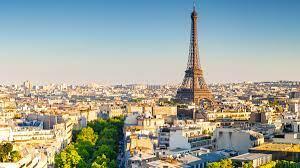

In [6]:
from IPython.display import Image, display

print("Content Image")
display(Image(base_image_path))

Style Image


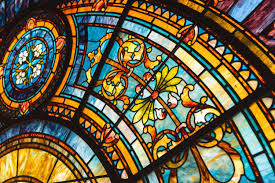

In [7]:
print("Style Image")
display(Image(style_reference_image_path))

In [8]:
def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1] #convert to RGB
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [9]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :]- x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [10]:
model = vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 [==============================] - 0s 0us/step


In [11]:

style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [12]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image) #dloss/dcombination
    return loss, grads

We can now optimize the image according to the loss function.

In [13]:
optimizer = keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96))

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image)
    optimizer.apply_gradients([(grads, combination_image)]) #backpropagate through the combination image
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = "image_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

Iteration 100: loss=17186.65
Iteration 200: loss=13228.32
Iteration 300: loss=11700.13
Iteration 400: loss=10847.77
Iteration 500: loss=10282.17
Iteration 600: loss=9873.85
Iteration 700: loss=9562.60
Iteration 800: loss=9316.54
Iteration 900: loss=9115.39
Iteration 1000: loss=8947.34
Iteration 1100: loss=8803.93
Iteration 1200: loss=8679.82
Iteration 1300: loss=8571.35
Iteration 1400: loss=8476.11
Iteration 1500: loss=8391.46
Iteration 1600: loss=8315.79
Iteration 1700: loss=8247.77
Iteration 1800: loss=8186.43
Iteration 1900: loss=8130.83
Iteration 2000: loss=8080.26
Iteration 2100: loss=8033.87
Iteration 2200: loss=7991.18
Iteration 2300: loss=7951.79
Iteration 2400: loss=7915.48
Iteration 2500: loss=7881.91
Iteration 2600: loss=7850.57
Iteration 2700: loss=7821.51
Iteration 2800: loss=7794.45
Iteration 2900: loss=7769.23
Iteration 3000: loss=7745.71
Iteration 3100: loss=7723.74
Iteration 3200: loss=7703.12
Iteration 3300: loss=7683.82
Iteration 3400: loss=7665.65
Iteration 3500: lo

We can display the image.

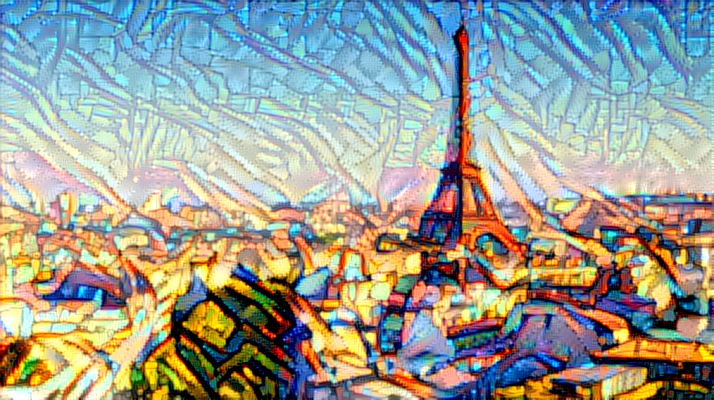

In [14]:
display(Image("image_at_iteration_4000.png"))

We can download this image.

In [15]:
from google.colab import files
files.download("image_at_iteration_4000.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>